## Step 1: Loading Data and Initial Exploration

First, let's load the `matches.csv` and `deliveries.csv` files into pandas DataFrames. We'll also merge them to create a comprehensive dataset.

In [1]:
import pandas as pd

# Load the datasets
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

# Merge the two dataframes for a combined view
# The 'id' column in matches corresponds to 'match_id' in deliveries
delivery_df = pd.merge(deliveries, matches, left_on='match_id', right_on='id')

print("Matches dataframe shape:", matches.shape)
print("Deliveries dataframe shape:", deliveries.shape)
print("Merged dataframe shape:", delivery_df.shape)

delivery_df.head()

Matches dataframe shape: (1095, 20)
Deliveries dataframe shape: (260920, 17)
Merged dataframe shape: (260920, 37)


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


## Step 2: Quantifying Player Performance

Now, we'll calculate key performance metrics for each player. We'll create separate statistics for batting and bowling.

In [2]:

# Batting Performance Metrics

# Group by batter to calculate career stats
batsman_grp = delivery_df.groupby('batter')

# Total runs scored by each batsman
batsman_runs = batsman_grp['batsman_runs'].sum().reset_index()
batsman_runs.rename(columns={'batsman_runs': 'total_runs'}, inplace=True)

# Total balls faced by each batsman (excluding wides)
balls_faced = delivery_df[delivery_df['extras_type'] != 'wides'].groupby('batter')['ball'].count().reset_index()
balls_faced.rename(columns={'ball': 'balls_faced'}, inplace=True)

# Calculate Strike Rate
player_stats = pd.merge(batsman_runs, balls_faced, on='batter')
player_stats['strike_rate'] = (player_stats['total_runs'] / player_stats['balls_faced']) * 100

# Calculate Batting Average
dismissals = delivery_df[delivery_df['player_dismissed'].notna()].groupby('player_dismissed').size().reset_index(name='dismissals')
dismissals.rename(columns={'player_dismissed': 'batter'}, inplace=True)
player_stats = pd.merge(player_stats, dismissals, on='batter', how='left')

# --- FIX: Avoid inplace on a chained selection ---
player_stats['dismissals'] = player_stats['dismissals'].fillna(0)

player_stats['batting_average'] = player_stats['total_runs'] / (player_stats['dismissals']+1)
# Handle division by zero for players who have never been dismissed
# --- FIX: Avoid inplace on a chained selection ---
player_stats['batting_average'] = player_stats['batting_average'].fillna(0)


print("Batting Stats:")
player_stats.head()

Batting Stats:


,batter,total_runs,balls_faced,strike_rate,dismissals,batting_average
0,A Ashish Reddy,280,193,145.077720,15.0,17.500000
1,A Badoni,634,473,134.038055,26.0,23.481481
2,A Chandila,4,7,57.142857,0.0,4.000000
3,A Chopra,53,71,74.647887,6.0,7.571429
4,A Choudhary,25,20,125.000000,1.0,12.500000


In [3]:

# Bowling Performance Metrics

# Group by bowler to calculate career stats
bowler_grp = delivery_df.groupby('bowler')

# Total runs conceded by each bowler
runs_conceded = bowler_grp['total_runs'].sum().reset_index()
runs_conceded.rename(columns={'total_runs': 'runs_conceded'}, inplace=True)

# Total balls bowled by each bowler
balls_bowled = delivery_df.groupby('bowler')['ball'].count().reset_index()
balls_bowled.rename(columns={'ball': 'balls_bowled'}, inplace=True)

# Calculate Economy Rate
bowler_stats = pd.merge(runs_conceded, balls_bowled, on='bowler')
bowler_stats['economy_rate'] = (bowler_stats['runs_conceded'] / bowler_stats['balls_bowled']) * 6

# Total wickets taken
wickets_taken = delivery_df[delivery_df['dismissal_kind'].notna() & ~delivery_df['dismissal_kind'].isin(['run out', 'retired hurt', 'obstructing the field'])].groupby('bowler').size().reset_index(name='wickets')
bowler_stats = pd.merge(bowler_stats, wickets_taken, on='bowler', how='left')

# --- FIX: Avoid inplace on a chained selection ---
bowler_stats['wickets'] = bowler_stats['wickets'].fillna(0)

# Calculate Bowling Average
bowler_stats['bowling_average'] = bowler_stats['runs_conceded'] / (bowler_stats['wickets']+1)
# Handle division by zero for bowlers with no wickets
# --- FIX: Replace infinity with 0 after division ---
bowler_stats['bowling_average'] = bowler_stats['bowling_average'].replace([float('inf')], 0)


print("Bowling Stats:")
bowler_stats.head()

Bowling Stats:


,bowler,runs_conceded,balls_bowled,economy_rate,wickets,bowling_average
0,A Ashish Reddy,400,270,8.888889,18.0,21.052632
1,A Badoni,37,25,8.880000,2.0,12.333333
2,A Chandila,245,234,6.282051,11.0,20.416667
3,A Choudhary,144,108,8.000000,5.0,24.000000
4,A Dananjaya,47,25,11.280000,0.0,47.000000


## Step 3: Context-Based Performance Analysis

Here, we'll analyze player performance against specific opposition teams and at different venues. This will allow us to create features that are sensitive to the match context.

In [4]:
# Batting performance against a specific opposition
def get_batsman_vs_opposition_stats(batter_name, opposition_team, df):
    df_filtered = df[df['batter'] == batter_name]
    df_filtered = df_filtered[df_filtered['bowling_team'] == opposition_team]
    
    if df_filtered.empty:
        return None
    
    total_runs = df_filtered['batsman_runs'].sum()
    balls_faced = df_filtered[df_filtered['extras_type'] != 'wides'].shape[0]
    dismissals = df_filtered[df_filtered['player_dismissed'] == batter_name].shape[0]
    
    strike_rate = (total_runs / balls_faced) * 100 if balls_faced > 0 else 0
    batting_average = total_runs / dismissals if dismissals > 0 else total_runs
    
    return {'runs': total_runs, 'sr': strike_rate, 'avg': batting_average}

# Example: Virat Kohli vs Chennai Super Kings
kohli_vs_csk = get_batsman_vs_opposition_stats('V Kohli', 'Chennai Super Kings', delivery_df)
print(f"Virat Kohli vs CSK: {kohli_vs_csk}")

Virat Kohli vs CSK: {'runs': np.int64(1053), 'sr': np.float64(126.25899280575538), 'avg': np.float64(37.607142857142854)}


In [5]:
# Bowling performance against a specific opposition
def get_bowler_vs_opposition_stats(bowler_name, opposition_team, df):
    df_filtered = df[df['bowler'] == bowler_name]
    df_filtered = df_filtered[df_filtered['batting_team'] == opposition_team]
    
    if df_filtered.empty:
        return None
        
    runs_conceded = df_filtered['total_runs'].sum()
    balls_bowled = df_filtered.shape[0]
    wickets = df_filtered[df_filtered['dismissal_kind'].notna() & ~df_filtered['dismissal_kind'].isin(['run out', 'retired hurt', 'obstructing the field'])].shape[0]
    
    economy = (runs_conceded / balls_bowled) * 6 if balls_bowled > 0 else 0
    bowling_average = runs_conceded / wickets if wickets > 0 else runs_conceded
    
    return {'wickets': wickets, 'econ': economy, 'avg': bowling_average}

# Example: Jasprit Bumrah vs Kolkata Knight Riders
bumrah_vs_kkr = get_bowler_vs_opposition_stats('JJ Bumrah', 'Kolkata Knight Riders', delivery_df)
print(f"JJ Bumrah vs KKR: {bumrah_vs_kkr}")

JJ Bumrah vs KKR: {'wickets': 25, 'econ': np.float64(7.8248175182481745), 'avg': np.float64(21.44)}


These functions are useful for getting specific matchups. For our model, it will be more efficient to pre-calculate these stats for all players.

Let's create comprehensive dataframes for these context-based stats.

In [6]:
# Pre-calculate all batsman-vs-opposition stats
batsman_vs_opposition = delivery_df.groupby(['batter', 'bowling_team']).agg(
    runs=('batsman_runs', 'sum'),
    balls=('ball', lambda x: delivery_df.loc[x.index][delivery_df.loc[x.index, 'extras_type'] != 'wides'].shape[0]),
    dismissals=('player_dismissed', lambda x: x.notna().sum())
).reset_index()

batsman_vs_opposition['strike_rate'] = (batsman_vs_opposition['runs'] / batsman_vs_opposition['balls']) * 100
batsman_vs_opposition['average'] = batsman_vs_opposition['runs'] / (batsman_vs_opposition['dismissals']+1)
batsman_vs_opposition.fillna({'average': 0, 'strike_rate': 0}, inplace=True)
batsman_vs_opposition['average'] = batsman_vs_opposition['average'].replace([float('inf')], 0)

print("Batsman vs Opposition Stats:")
batsman_vs_opposition.head()

Batsman vs Opposition Stats:


,batter,bowling_team,runs,balls,dismissals,strike_rate,average
0,A Ashish Reddy,Chennai Super Kings,45,25,2,180.000000,15.000000
1,A Ashish Reddy,Delhi Daredevils,36,23,3,156.521739,9.000000
2,A Ashish Reddy,Kings XI Punjab,37,23,1,160.869565,18.500000
3,A Ashish Reddy,Kolkata Knight Riders,17,13,2,130.769231,5.666667
4,A Ashish Reddy,Mumbai Indians,27,25,2,108.000000,9.000000


In [7]:
import numpy as np

# Pre-calculate all bowler-vs-opposition stats

# This lambda returns the count of valid wicket types (exclude run out / retired hurt / obstructing the field)
bowler_vs_opposition = delivery_df.groupby(['bowler', 'batting_team']).agg(
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('ball', 'count'),
    wickets=('dismissal_kind', lambda x: (~x.isin(['run out', 'retired hurt', 'obstructing the field']) & x.notna()).sum())
).reset_index()

bowler_vs_opposition['economy'] = (bowler_vs_opposition['runs_conceded'] / bowler_vs_opposition['balls_bowled']) * 6

# Compute average safely (avoid division by zero)
bowler_vs_opposition['average'] = bowler_vs_opposition['runs_conceded'] / (bowler_vs_opposition['wickets']+1)

print("Bowler vs Opposition Stats:")
bowler_vs_opposition.head()

Bowler vs Opposition Stats:


,bowler,batting_team,runs_conceded,balls_bowled,wickets,economy,average
0,A Ashish Reddy,Chennai Super Kings,50,30,2,10.000000,16.666667
1,A Ashish Reddy,Delhi Daredevils,45,25,1,10.800000,22.500000
2,A Ashish Reddy,Kings XI Punjab,40,25,2,9.600000,13.333333
3,A Ashish Reddy,Kolkata Knight Riders,29,24,2,7.250000,9.666667
4,A Ashish Reddy,Mumbai Indians,11,14,1,4.714286,5.500000


## Step 4: Defining Player Roles

To build a balanced team, we first need to classify players into roles like Batsman, Bowler, All-Rounder, and Wicketkeeper. We'll use their career stats to create these roles.

In [8]:
# Merge overall batting and bowling stats
player_stats.rename(columns={'batter': 'player'}, inplace=True)
bowler_stats.rename(columns={'bowler': 'player'}, inplace=True)

players_df = pd.merge(player_stats, bowler_stats, on='player', how='outer')
players_df.fillna(0, inplace=True)

# Define roles based on heuristics
def get_player_role(player_row):
    balls_bowled = player_row['balls_bowled']
    balls_faced = player_row['balls_faced']
    
    # Heuristics: these thresholds can be tuned
    is_bowler = balls_bowled > 100
    is_batsman = balls_faced > 100
    
    if is_batsman and not is_bowler:
        return 'Batsman'
    if is_bowler and not is_batsman:
        return 'Bowler'
    if is_batsman and is_bowler:
        return 'All-Rounder'
    return 'Other' # Players with very little match time

players_df['role'] = players_df.apply(get_player_role, axis=1)

# Identify Wicketkeepers (based on stumping dismissals)
stumpings = delivery_df[delivery_df['dismissal_kind'] == 'stumped']['fielder'].value_counts().reset_index()
stumpings.rename(columns={'fielder': 'player', 'count': 'stumpings'}, inplace=True)
players_df = pd.merge(players_df, stumpings, on='player', how='left')
players_df['stumpings'] = players_df['stumpings'].fillna(0)

# A player with stumpings is likely a Wicketkeeper
players_df.loc[players_df['stumpings'] > 0, 'role'] = 'Wicketkeeper'

print("Player Roles Distribution:")
print(players_df['role'].value_counts())

players_df[['player', 'role', 'total_runs', 'balls_faced', 'wickets', 'balls_bowled']].head()

Player Roles Distribution:
role
Other           219
Bowler          213
Batsman         135
All-Rounder     124
Wicketkeeper     41
Name: count, dtype: int64


,player,role,total_runs,balls_faced,wickets,balls_bowled
0,A Ashish Reddy,All-Rounder,280.0,193.0,18.0,270.0
1,A Badoni,Batsman,634.0,473.0,2.0,25.0
2,A Chandila,Bowler,4.0,7.0,11.0,234.0
3,A Chopra,Other,53.0,71.0,0.0,0.0
4,A Choudhary,Bowler,25.0,20.0,5.0,108.0


## Step 5: Building a Match Prediction Model

Now for the most critical part. We need to create a dataset where each row represents a match, with features describing the strengths of the two teams. Then we'll train a model to predict the winner.

In [9]:
from tqdm import tqdm

def get_match_features(match, delivery_df, batsman_vs_opp, bowler_vs_opp):
    match_id = match['id']
    team1 = match['team1']
    team2 = match['team2']
    venue = match['venue']
    
    # Get players for this match
    match_deliveries = delivery_df[delivery_df['match_id'] == match_id]
    team1_players = match_deliveries[match_deliveries['batting_team'] == team1]['batter'].unique()
    team2_players = match_deliveries[match_deliveries['batting_team'] == team2]['batter'].unique()
    
    if len(team1_players) == 0 or len(team2_players) == 0:
        return None
        
    # Get team stats vs opposition
    team1_bat_stats = batsman_vs_opp[(batsman_vs_opp['batter'].isin(team1_players)) & (batsman_vs_opp['bowling_team'] == team2)]
    team2_bat_stats = batsman_vs_opp[(batsman_vs_opp['batter'].isin(team2_players)) & (batsman_vs_opp['bowling_team'] == team1)]
    
    team1_bowl_stats = bowler_vs_opp[(bowler_vs_opp['bowler'].isin(team1_players)) & (bowler_vs_opp['batting_team'] == team2)]
    team2_bowl_stats = bowler_vs_opp[(bowler_vs_opp['bowler'].isin(team2_players)) & (bowler_vs_opp['batting_team'] == team1)]
    
    features = {
        'team1_bat_avg': team1_bat_stats['average'].mean(),
        'team1_bat_sr': team1_bat_stats['strike_rate'].mean(),
        'team2_bat_avg': team2_bat_stats['average'].mean(),
        'team2_bat_sr': team2_bat_stats['strike_rate'].mean(),
        'team1_bowl_avg': team1_bowl_stats['average'].mean(),
        'team1_bowl_econ': team1_bowl_stats['economy'].mean(),
        'team2_bowl_avg': team2_bowl_stats['average'].mean(),
        'team2_bowl_econ': team2_bowl_stats['economy'].mean(),
        'toss_winner_is_team1': 1 if match['toss_winner'] == team1 else 0,
        'winner': 1 if match['winner'] == team1 else 0 # Target variable
    }
    
    return features

# Create the training data
training_data = []
for index, row in tqdm(matches.iterrows(), total=matches.shape[0], desc="Creating Match Features"):
    match_features = get_match_features(row, delivery_df, batsman_vs_opposition, bowler_vs_opposition)
    if match_features:
        training_data.append(match_features)

training_df = pd.DataFrame(training_data)
training_df.dropna(inplace=True)

print(f"Created training data with {training_df.shape[0]} matches.")
training_df.head()

Creating Match Features: 100%|██████████| 1095/1095 [00:05<00:00, 193.14it/s]

Created training data with 1048 matches.


,team1_bat_avg,team1_bat_sr,team2_bat_avg,team2_bat_sr,team1_bowl_avg,team1_bowl_econ,team2_bowl_avg,team2_bowl_econ,toss_winner_is_team1,winner
0,14.217845,85.608008,19.878571,124.667688,28.731250,9.678479,17.916667,7.788557,1,0
1,21.435847,128.805586,36.031548,138.422691,47.187500,9.213302,34.375000,8.324029,0,0
2,26.934231,136.378235,15.428242,97.300963,12.666667,8.142857,28.603968,7.578433,0,1
3,14.796726,114.075339,24.360995,121.699189,41.083333,7.413589,26.250000,7.613919,1,0
4,18.528571,105.580873,13.896732,104.901177,15.000000,7.487780,24.226190,7.487496,0,1


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define features (X) and target (y)
X = training_df.drop('winner', axis=1)
y = training_df['winner']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Match Prediction Model Accuracy: {accuracy:.2f}")

Match Prediction Model Accuracy: 0.74


## Step 6: Optimal Playing XI Selection

This is the final step where we use our trained model to select the optimal playing XI. We'll use a greedy algorithm that iteratively builds a team by selecting players who provide the maximum increase in win probability, while respecting team composition constraints.

In [11]:
import numpy as np

def calculate_win_prob(team1_players, team2_players, match_context):
    """Calculates the win probability for team1 based on the provided player lists."""
    team1 = match_context['team1']
    team2 = match_context['team2']

    # Get aggregated stats for the provided player lists
    team1_bat_stats = batsman_vs_opposition[(batsman_vs_opposition['batter'].isin(team1_players)) & (batsman_vs_opposition['bowling_team'] == team2)]
    team2_bat_stats = batsman_vs_opposition[(batsman_vs_opposition['batter'].isin(team2_players)) & (batsman_vs_opposition['bowling_team'] == team1)]
    team1_bowl_stats = bowler_vs_opposition[(bowler_vs_opposition['bowler'].isin(team1_players)) & (bowler_vs_opposition['batting_team'] == team2)]
    team2_bowl_stats = bowler_vs_opposition[(bowler_vs_opposition['bowler'].isin(team2_players)) & (bowler_vs_opposition['batting_team'] == team1)]

    # Create the feature vector for the model
    features = {
        'team1_bat_avg': team1_bat_stats['average'].mean(),
        'team1_bat_sr': team1_bat_stats['strike_rate'].mean(),
        'team2_bat_avg': team2_bat_stats['average'].mean(),
        'team2_bat_sr': team2_bat_stats['strike_rate'].mean(),
        'team1_bowl_avg': team1_bowl_stats['average'].mean(),
        'team1_bowl_econ': team1_bowl_stats['economy'].mean(),
        'team2_bowl_avg': team2_bowl_stats['average'].mean(),
        'team2_bowl_econ': team2_bowl_stats['economy'].mean(),
        'toss_winner_is_team1': match_context['toss_winner_is_team1']
    }
    
    # Convert to DataFrame, handle potential NaNs
    feature_df = pd.DataFrame([features])
    feature_df.fillna(0, inplace=True)
    
    # Predict probability
    win_prob = log_reg.predict_proba(feature_df)[0][1] # Probability of team1 winning
    return win_prob

In [12]:
def predict_optimal_xi(team1_squad, team2_squad, match_context):
    """Selects the best 11 players for team1 using a greedy approach."""
    
    # Define team composition constraints
    constraints = {'Wicketkeeper': 1, 'Batsman': 4, 'All-Rounder': 2, 'Bowler': 4}
    
    optimal_xi = []
    available_players = team1_squad.copy()
    
    # Start with a baseline opponent XI (e.g., their most experienced players)
    # For simplicity, we'll use the whole squad. A better approach might be to predict their XI too.
    opponent_xi = team2_squad 
    
    # Iteratively build the team for 11 slots
    for i in range(11):
        best_player = None
        max_win_prob = -1
        
        # Get current role counts in the selected XI
        current_roles = pd.Series([players_df[players_df['player'] == p]['role'].values[0] for p in optimal_xi]).value_counts()

        for player in available_players:
            player_role = players_df[players_df['player'] == player]['role'].values[0]
            
            # Check if adding this player violates constraints
            if current_roles.get(player_role, 0) >= constraints.get(player_role, 0):
                continue
                
            # Temporarily add player and calculate new win probability
            temp_xi = optimal_xi + [player]
            win_prob = calculate_win_prob(temp_xi, opponent_xi, match_context)
            
            if win_prob > max_win_prob:
                max_win_prob = win_prob
                best_player = player
        
        if best_player:
            optimal_xi.append(best_player)
            available_players.remove(best_player)
        else:
            # If no player can be added due to constraints, break
            break
            
    return optimal_xi, max_win_prob

# --- Example Usage ---
# 1. Define the match context
team1 = 'Mumbai Indians'
team2 = 'Chennai Super Kings'
venue = 'Wankhede Stadium'

match_context = {
    'team1': team1,
    'team2': team2,
    'venue': venue,
    'toss_winner_is_team1': 1 # Assume team1 wins the toss
}

# 2. Define the player squads (full list of available players for each team)
# For this example, we'll get all players who have ever played for these teams
mi_players = delivery_df[delivery_df['batting_team'] == team1]['batter'].unique().tolist()
csk_players = delivery_df[delivery_df['batting_team'] == team2]['batter'].unique().tolist()

# 3. Predict the optimal XI
optimal_mi_xi, win_prob = predict_optimal_xi(mi_players, csk_players, match_context)

print(f"Optimal XI for {team1} against {team2}:")
for player in optimal_mi_xi:
    role = players_df[players_df['player'] == player]['role'].values[0]
    print(f"- {player} ({role})")

print(f"\nPredicted Win Probability: {win_prob:.2%}")

Optimal XI for Mumbai Indians against Chennai Super Kings:
- JC Archer (All-Rounder)
- J Yadav (Bowler)
- PR Shah (Wicketkeeper)
- AG Murtaza (Bowler)
- MJ Guptill (Batsman)
- TS Mills (Bowler)
- K Kartikeya (Bowler)
- BCJ Cutting (All-Rounder)
- S Dhawan (Batsman)
- E Lewis (Batsman)
- Tilak Varma (Batsman)

Predicted Win Probability: 98.93%


In [13]:
# ---- Additional imports for modeling & visualization ----
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import defaultdict

# XGBoost optional
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    XGBClassifier = None
    xgb_available = False
    print('xgboost not available, will skip XGBClassifier.')

# For imbalanced data handling (optional)
try:
    from imblearn.over_sampling import SMOTE
    imblearn_available = True
except Exception as e:
    SMOTE = None
    imblearn_available = False
    print('imblearn not available, will skip SMOTE oversampling.')

print('Libraries ready.')


Libraries ready.


Data snapshot:


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


Constructed aggregated player-match table with target "selected".


,match_id,player,runs,wickets,impact,rank,selected
0,335982,AA Noffke,9,1.0,29.0,5.0,1
1,335982,B Akhil,0,1.0,20.0,14.0,0
2,335982,BB McCullum,158,0.0,158.0,1.0,1
3,335982,CL White,6,1.0,26.0,8.0,1
4,335982,DJ Hussey,12,1.0,32.0,3.0,1


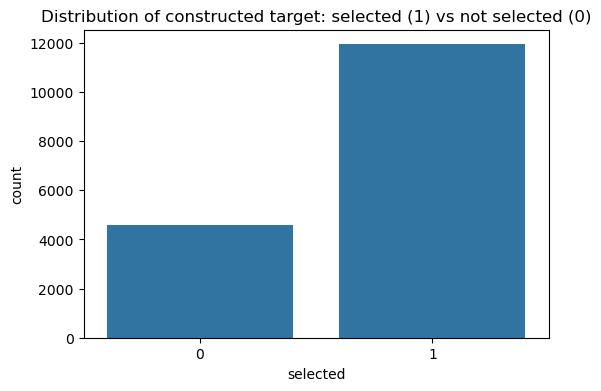

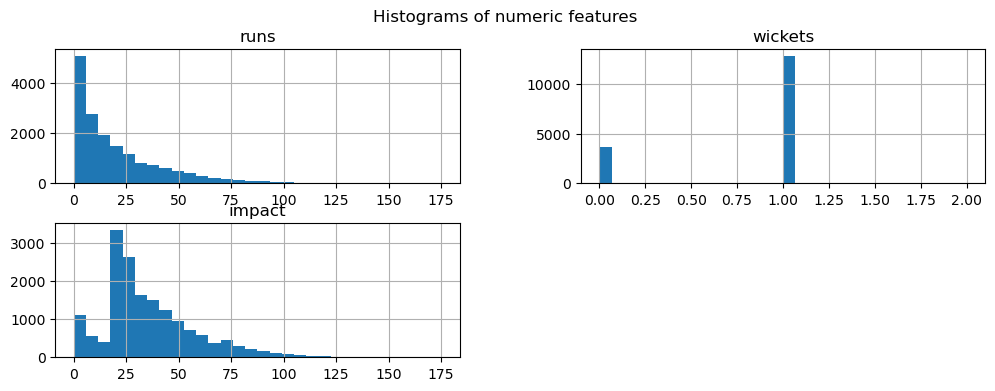

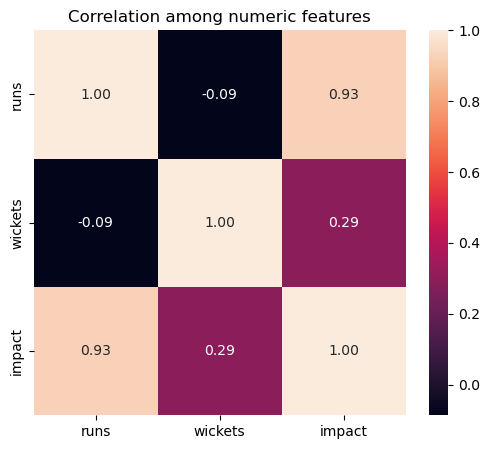

In [14]:
# ---- Basic EDA & preprocessing visualizations ----
# We assume 'delivery_df' from original notebook is available and contains player and match info.
df = delivery_df.copy()
print('Data snapshot:')
display(df.head())

# Example of constructing a target: whether a player appears in final playing XI of a match
# The Kaggle IPL dataset uses 'player_dismissed' etc; however original notebook likely created features.
# We'll build a simple example target: for each match, the top 11 batsmen by 'batsman_runs' + bowlers by wickets
# NOTE: This is a heuristic placeholder — adapt to your original target if different.

# Aggregate runs and wickets by player per match
bats = df.groupby(['match_id','batter'])['batsman_runs'].sum().reset_index().rename(columns={'batter':'player','batsman_runs':'runs'})
wkts = df[df['player_dismissed'].notna()].groupby(['match_id','player_dismissed']).size().reset_index().rename(columns={'player_dismissed':'player',0:'wickets'})

agg = pd.merge(bats, wkts, how='left', on=['match_id','player']).fillna(0)
agg['impact'] = agg['runs'] + 20*agg['wickets']  # simple impact score
# For each match, mark top-11 impact players as 'selected'
agg['rank'] = agg.groupby('match_id')['impact'].rank(method='first', ascending=False)
agg['selected'] = (agg['rank'] <= 11).astype(int)

print('Constructed aggregated player-match table with target "selected".')
display(agg.head())

# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='selected', data=agg)
plt.title('Distribution of constructed target: selected (1) vs not selected (0)')
plt.show()

# Numeric distribution examples
num_cols = ['runs','wickets','impact']
agg[num_cols].hist(bins=30, figsize=(12,4))
plt.suptitle('Histograms of numeric features')
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(agg[num_cols].corr(), annot=True, fmt='.2f')
plt.title('Correlation among numeric features')
plt.show()


In [15]:
# Over-phase stats + finer player role classification
# Depends on: delivery_df, players_df (from previous cells)

# 1) Ensure 'over' exists (fallback: compute from delivery order per match+inning)
if 'over' not in delivery_df.columns:
    delivery_df = delivery_df.sort_values(['match_id', 'inning', 'ball']).copy()
    delivery_df['delivery_index'] = delivery_df.groupby(['match_id', 'inning']).cumcount()
    delivery_df['over'] = (delivery_df['delivery_index'] // 6) + 1
    delivery_df.drop(columns=['delivery_index'], inplace=True)

# Define phases
def phase_from_over(o):
    if o <= 6:
        return 'powerplay'
    if 7 <= o <= 15:
        return 'middle'
    return 'death'

delivery_df['phase'] = delivery_df['over'].apply(phase_from_over)

# Exclude wides for balls faced/bowled calculations
no_wides = delivery_df[delivery_df.get('extras_type', None) != 'wides'].copy()

# 2) Batsman phase-wise stats
bats_phase = no_wides.groupby(['batter', 'phase']).agg(
    runs=('batsman_runs', 'sum'),
    balls=('ball', 'count'),
    fours=('batsman_runs', lambda x: (x==4).sum()),
    sixes=('batsman_runs', lambda x: (x==6).sum())
).reset_index()

# Pivot to wide form
bats_wide = bats_phase.pivot(index='batter', columns='phase', values=['runs','balls','fours','sixes'])
# flatten columns
bats_wide.columns = ['_'.join(col).strip() for col in bats_wide.columns.values]
bats_wide.reset_index(inplace=True)
# compute strike rates and boundary rates for death specifically
for ph in ['powerplay','middle','death']:
    runs_col = f'runs_{ph}'
    balls_col = f'balls_{ph}'
    sr_col = f'sr_{ph}'
    bats_wide[sr_col] = (bats_wide[runs_col] / bats_wide[balls_col] * 100).replace([np.inf], 0).fillna(0)
    # boundary rate
    bats_wide[f'boundary_rate_{ph}'] = ((bats_wide.get(f'fours_{ph}',0).fillna(0) + bats_wide.get(f'sixes_{ph}',0).fillna(0))
                                       / bats_wide[balls_col].replace(0, np.nan)).fillna(0)

# 3) Bowler phase-wise stats
# wickets: exclude run out / retired hurt / obstructing the field
valid_wicket_mask = (~delivery_df['dismissal_kind'].isin(['run out', 'retired hurt', 'obstructing the field'])) & delivery_df['dismissal_kind'].notna()
bowl_phase = delivery_df.groupby(['bowler', 'phase']).agg(
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('ball', lambda x: x.count()),  # includes wides - we'll filter using extras_type
    wickets=('dismissal_kind', lambda x: ((~x.isin(['run out', 'retired hurt', 'obstructing the field'])) & x.notna()).sum())
).reset_index()

# Accurate balls bowled excluding wides
balls_no_wide = delivery_df[delivery_df.get('extras_type', None) != 'wides'].groupby(['bowler','phase'])['ball'].count().reset_index(name='balls_no_wide')
bowl_phase = pd.merge(bowl_phase, balls_no_wide, on=['bowler','phase'], how='left')
bowl_phase['balls_no_wide'] = bowl_phase['balls_no_wide'].fillna(0)
bowl_phase['econ'] = (bowl_phase['runs_conceded'] / bowl_phase['balls_no_wide'] * 6).replace([np.inf], 0).fillna(0)

bowl_wide = bowl_phase.pivot(index='bowler', columns='phase', values=['runs_conceded','balls_no_wide','wickets','econ'])
bowl_wide.columns = ['_'.join(col).strip() for col in bowl_wide.columns.values]
bowl_wide.reset_index(inplace=True)

# 4) Batting position inference (per match + inning)
# Determine first-appearance batting order for each match+inning
bat_appear = (delivery_df.sort_values(['match_id','inning','over','ball'])
              .groupby(['match_id','inning'])['batter']
              .apply(lambda x: pd.Series(x.unique()).reset_index().rename(columns={0:'player', 'index':'pos'}))
              .reset_index(level=[0,1], drop=False)
             )

# The previous groupby/transform returns a MultiIndex-like object; reconstruct properly
# Alternative robust approach:
bat_pos_rows = []
for (m, inn), sub in delivery_df.sort_values(['match_id','inning','over','ball']).groupby(['match_id','inning']):
    unique_batters = pd.Series(sub['batter'].values).drop_duplicates().tolist()
    for idx, p in enumerate(unique_batters, start=1):
        bat_pos_rows.append({'match_id': m, 'inning': inn, 'player': p, 'pos': idx})
bat_pos_df = pd.DataFrame(bat_pos_rows)

# Compute per-player innings counts and positional stats
player_pos_stats = (bat_pos_df.groupby('player')
                    .agg(innings_played=('match_id','nunique'),
                         opens_count=('pos', lambda x: (x <= 2).sum()),
                         late_count=('pos', lambda x: (x >= 7).sum()))
                    .reset_index())

player_pos_stats['prop_open'] = player_pos_stats['opens_count'] / player_pos_stats['innings_played']
player_pos_stats['prop_late'] = player_pos_stats['late_count'] / player_pos_stats['innings_played']

# 5) Merge bats_wide & bowl_wide & player_pos_stats into players_df
players_roles = players_df.copy()
players_roles = players_roles.merge(bats_wide, left_on='player', right_on='batter', how='left').drop(columns=['batter'], errors='ignore')
players_roles = players_roles.merge(bowl_wide, left_on='player', right_on='bowler', how='left').drop(columns=['bowler'], errors='ignore')
players_roles = players_roles.merge(player_pos_stats, left_on='player', right_on='player', how='left')

# Fill NaNs
players_roles.fillna(0, inplace=True)

# 6) Role heuristics (tunable thresholds)
# Opening batsman: prop_open > 0.3 and balls_faced overall > 100
players_roles['is_opening'] = ((players_roles['prop_open'] > 0.30) & (players_roles['balls_faced'] > 100))

# Power hitter: high death SR and >20 balls in death and boundary_rate_death > 0.18
players_roles['is_power_hitter'] = ((players_roles['sr_death'] > 130) & (players_roles['balls_death'] > 20) & (players_roles['boundary_rate_death'] > 0.18))

# Finisher: often bats late + high death strike rate or high proportion of late positions
players_roles['is_finisher'] = ((players_roles['prop_late'] > 0.25) & (players_roles['sr_death'] > 110) & (players_roles['balls_death'] > 20))

# Anchor: high average, low sr (controls innings)
players_roles['is_anchor'] = ((players_roles['batting_average'] > 25) & (players_roles['strike_rate'] < 110) & (players_roles['balls_faced'] > 200))

# Death bowler: lots of death balls & reasonable econ there
players_roles['death_balls'] = players_roles['balls_no_wide_death'] if 'balls_no_wide_death' in players_roles.columns else 0
players_roles['is_death_bowler'] = ((players_roles['death_balls'] > 100) & (players_roles.get('econ_death', 999) <= 9.5) & (players_roles.get('wickets_death', 0) >= 10))

# Powerplay bowler: bowls many powerplay balls and low econ in powerplay
players_roles['pp_balls'] = players_roles['balls_no_wide_powerplay'] if 'balls_no_wide_powerplay' in players_roles.columns else 0
players_roles['is_powerplay_bowler'] = ((players_roles['pp_balls'] > 100) & (players_roles.get('econ_powerplay', 999) <= 8.5))

# Consolidate detailed role label (priority-based)
def detailed_role(row):
    if row['stumpings'] > 0:
        return 'Wicketkeeper'
    if row['is_opening']:
        return 'Opening Batsman'
    if row['is_power_hitter']:
        return 'Power Hitter'
    if row['is_finisher']:
        return 'Finisher'
    if row['is_anchor']:
        return 'Anchor'
    if row['is_death_bowler']:
        return 'Death Bowler'
    if row['is_powerplay_bowler']:
        return 'Powerplay Bowler'
    # fallback to earlier coarse role
    return row['role']

players_roles['role_detailed'] = players_roles.apply(detailed_role, axis=1)

# 7) Persist back into notebook-level players_df (so subsequent cells can use it)
players_df = players_roles

# Quick checks: show top candidates for each new detailed role
print("Top Opening Batsmen (by prop_open):")
print(players_df[players_df['is_opening']].sort_values('prop_open', ascending=False)[['player','prop_open','balls_faced']].head(10))

print("\nTop Power Hitters (by boundary_rate_death & sr_death):")
print(players_df[players_df['is_power_hitter']].sort_values(['boundary_rate_death','sr_death'], ascending=False)[['player','boundary_rate_death','sr_death','balls_death']].head(10))

print("\nTop Death Bowlers (by death_balls & econ_death):")
print(players_df[players_df['is_death_bowler']].sort_values(['death_balls','econ_death'], ascending=[False,True])[['player','death_balls','econ_death','wickets_death']].head(10))

print("\nRole distribution (detailed):")
print(players_df['role_detailed'].value_counts().head(20))

Top Opening Batsmen (by prop_open):
          player  prop_open  balls_faced
385   MJ Guptill   1.076923        197.0
207     GC Smith   1.000000        668.0
37      AD Hales   1.000000        118.0
317    KR Mayers   1.000000        263.0
631  Salman Butt   1.000000        161.0
720  YBK Jaiswal   1.000000       1067.0
481      PP Shaw   1.000000       1283.0
343  LMP Simmons   1.000000        852.0
387      MJ Lumb   1.000000        194.0
166    DJ Harris   1.000000        101.0

Top Power Hitters (by boundary_rate_death & sr_death):
              player  boundary_rate_death    sr_death  balls_death
342        LJ Wright             0.451613  232.258065         31.0
661         T Stubbs             0.416667  277.380952         84.0
506       R Shepherd             0.384615  230.769231         39.0
115        BJ Rohrer             0.366667  243.333333         30.0
229          HM Amla             0.358974  207.692308         39.0
675          TR Birt             0.357143  182.142857  

In [23]:
# Code to pick optimal XI using existing model and assign batting + bowling orders
# Uses notebook-level objects: predict_optimal_xi, calculate_win_prob, players_df, batsman_vs_opposition, bowler_vs_opposition, mi_players, csk_players, log_reg

def assign_batting_order(xi, players_index):
    """Return a batting order (list) for XI based on detailed roles & phase stats."""
    info = []
    for p in xi:
        if p not in players_index.index:
            info.append((p, 0, 0, 0, 'Other'))  # fallback
            continue
        row = players_index.loc[p]
        prop_open = row.get('prop_open', 0) if 'prop_open' in row.index else 0
        is_open = bool(row.get('is_opening', False))
        is_finisher = bool(row.get('is_finisher', False))
        is_anchor = bool(row.get('is_anchor', False))
        sr_death = float(row.get('sr_death', 0))
        avg = float(row.get('batting_average', row.get('batting_average', 0)))
        role_det = row.get('role_detailed', row.get('role', 'Other'))
        info.append((p, prop_open, is_open, is_finisher, is_anchor, sr_death, avg, role_det))
    # Build order:
    # 1-2: openings prioritized by is_opening then prop_open
    opens = sorted([t for t in info if t[2]], key=lambda x: (-x[1], -x[6]))
    non_opens = [t for t in info if t not in opens]
    # If less than 2 openings, fill from best anchors/high avg
    order = [p[0] for p in opens[:2]]
    remaining = non_opens
    if len(order) < 2:
        candidates = sorted(remaining, key=lambda x: (-x[6], -x[5]))  # avg then sr_death
        while len(order) < 2 and candidates:
            order.append(candidates[0][0])
            remaining = [r for r in remaining if r[0] != candidates[0][0]]
            candidates = candidates[1:]
    # Middle overs (3-6): anchors / high average
    middles = sorted(remaining, key=lambda x: ((not x[4]), -x[6]))  # anchors first then avg
    for t in middles:
        if len(order) >= 6:
            break
        order.append(t[0])
    # Finishers (7-9): finisher/power hitters by sr_death
    remaining = [r for r in remaining if r[0] not in order]
    finishers = sorted(remaining, key=lambda x: (-int(x[3]), -x[5], -x[6]))  # is_finisher, sr_death, avg
    for t in finishers:
        if len(order) >= 9:
            break
        order.append(t[0])
    # Fill remaining slots with best by avg/sr
    remaining = [r for r in remaining if r[0] not in order]
    fillers = sorted(remaining, key=lambda x: (-x[6], -x[5]))
    for t in fillers:
        if len(order) >= 11:
            break
        order.append(t[0])
    # Ensure wicketkeeper upfront (position around 4-6) if present
    wk = [p for p in xi if players_index.loc[p].get('stumpings', 0) > 0] if all(p in players_index.index for p in xi) else []
    if wk:
        wkp = wk[0]
        if wkp in order:
            # move to position 5 if not already early
            order.remove(wkp)
            insert_pos = min(5, len(order))
            order.insert(insert_pos, wkp)
    return order

def assign_bowling_order(xi, squad, players_index, max_bowlers=5):
    """
    Select 5-6 bowlers prioritized by:
     - death bowlers (is_death_bowler)
     - powerplay bowlers (is_powerplay_bowler)
     - bowlers with high wickets and reasonable econ
    Returns ordered list of bowlers: [opening1, opening2, main1, main2, death1 (..)]
    """
    # Candidate source: selected XI first, then squad if needed
    candidates = []
    for p in xi + [p for p in squad if p not in xi]:
        if p not in players_index.index:
            continue
        r = players_index.loc[p]
        # bowling capability approx
        balls_bowled = r.get('balls_bowled', r.get('balls_bowled', 0))
        wickets = r.get('wickets', 0)
        death_balls = r.get('death_balls', r.get('balls_no_wide_death', 0))
        is_death = bool(r.get('is_death_bowler', False))
        is_pp = bool(r.get('is_powerplay_bowler', False))
        econ_death = r.get('econ_death', r.get('econ_death', 999))
        econ_overall = r.get('economy_rate', r.get('econ', r.get('economy', 999)))
        # score: prefer bowlers who bowl lots, take wickets, and deaths/powerplay specialists
        score = (
            (1.5 if is_death else 0) +
            (1.2 if is_pp else 0) +
            (min(balls_bowled / 200, 1.0)) +  # experience weight
            (min(wickets / 50, 1.0)) -
            (min(econ_death / 20, 1.0))  # penalize high death econ
        )
        candidates.append((p, score, is_pp, is_death, balls_bowled, wickets, econ_overall))
    # sort: prefer powerplay openers first, then main, then death specialists
    pp_candidates = [c for c in candidates if c[2]]
    pp_sorted = sorted(pp_candidates, key=lambda x: (-x[1], -x[5]))
    rest = [c for c in candidates if c not in pp_candidates]
    death_candidates = sorted([c for c in rest if c[3]], key=lambda x: (-x[1], -x[5]))
    middle_candidates = sorted([c for c in rest if not c[3] and not c[2]], key=lambda x: (-x[1], -x[5]))
    ordered = []
    # Add two powerplay bowlers if available
    for c in pp_sorted:
        if len(ordered) >= 2:
            break
        ordered.append(c[0])
    # Add two main bowlers
    for c in middle_candidates:
        if len(ordered) >= 4:
            break
        if c[0] not in ordered:
            ordered.append(c[0])
    # Add death bowlers
    for c in death_candidates:
        if len(ordered) >= max_bowlers:
            break
        if c[0] not in ordered:
            ordered.append(c[0])
    # If still not enough, fill from remaining best candidates
    remaining = [c for c in candidates if c[0] not in ordered]
    remaining_sorted = sorted(remaining, key=lambda x: (-x[1], -x[5]))
    for c in remaining_sorted:
        if len(ordered) >= max_bowlers:
            break
        ordered.append(c[0])
    return ordered[:max_bowlers]

# Use the existing predict_optimal_xi to get optimal XI for chosen teams & match context
# Adjust these inputs as required; using previously defined variables if available (team1, team2, mi_players, csk_players)
try:
    # If mi_players/csk_players exist from earlier example, use them; else construct from delivery_df
    team1_squad = mi_players if 'mi_players' in globals() else delivery_df[delivery_df['batting_team'] == team1]['batter'].unique().tolist()
    team2_squad = csk_players if 'csk_players' in globals() else delivery_df[delivery_df['batting_team'] == team2]['batter'].unique().tolist()
    # Reuse match_context as defined earlier, else create minimal context
    if 'match_context' not in globals():
        match_context = {'team1': team1, 'team2': team2, 'venue': venue if 'venue' in globals() else None, 'toss_winner_is_team1': 1}
    else:
        match_context = globals()['match_context']
    optimal_xi, opt_win_prob = predict_optimal_xi(team1_squad, team2_squad, match_context)
except Exception as e:
    raise RuntimeError(f"Could not compute optimal XI via predict_optimal_xi: {e}")

# Prepare players index for fast lookup
players_index = players_df.set_index('player')

# Assign batting order and bowling order (5 bowlers)
batting_order = assign_batting_order(optimal_xi, players_index)
bowling_order = assign_bowling_order(optimal_xi, team1_squad, players_index, max_bowlers=5)

# Display results
print(f"Optimal XI ({len(optimal_xi)}):")
for p in optimal_xi:
    role = players_index.loc[p].get('role_detailed', players_index.loc[p].get('role', 'Other')) if p in players_index.index else 'Unknown'
    print(f"- {p} ({role})")

print("\nAssigned Batting Order (1..11):")
for i, p in enumerate(batting_order, start=1):
    print(f"{i}. {p}")

print("\nAssigned Bowling Order (5 selected bowlers, approximate sequence):")
for i, p in enumerate(bowling_order, start=1):
    r = players_index.loc[p] if p in players_index.index else {}
    print(f"{i}. {p}  | wickets: {int(r.get('wickets',0))}  | death_balls: {int(r.get('death_balls', r.get('balls_no_wide_death',0)))}  | econ_death: {r.get('econ_death', r.get('econ_death', 'NA'))}")

print(f"\nPredicted win probability for this XI vs opponent baseline: {opt_win_prob:.3%}")

Optimal XI (11):
- JC Archer (Power Hitter)
- J Yadav (Powerplay Bowler)
- PR Shah (Wicketkeeper)
- AG Murtaza (Bowler)
- MJ Guptill (Opening Batsman)
- TS Mills (Bowler)
- K Kartikeya (Bowler)
- BCJ Cutting (Power Hitter)
- S Dhawan (Opening Batsman)
- E Lewis (Opening Batsman)
- Tilak Varma (Power Hitter)

Assigned Batting Order (1..11):
1. MJ Guptill
2. S Dhawan
3. Tilak Varma
4. BCJ Cutting
5. JC Archer
6. PR Shah
7. J Yadav
8. K Kartikeya
9. AG Murtaza
10. TS Mills

Assigned Bowling Order (5 selected bowlers, approximate sequence):
1. SL Malinga  | wickets: 170  | death_balls: 924  | econ_death: 8.12987012987013
2. JJ Bumrah  | wickets: 168  | death_balls: 1132  | econ_death: 8.485865724381625
3. HH Pandya  | wickets: 64  | death_balls: 178  | econ_death: 12.337078651685392
4. Yuvraj Singh  | wickets: 36  | death_balls: 67  | econ_death: 8.686567164179104
5. Harbhajan Singh  | wickets: 150  | death_balls: 178  | econ_death: 8.696629213483146

Predicted win probability for this XI 

In [24]:
from collections import defaultdict
import pandas as _pd

# Assign overs (1-20) to selected bowlers based on role suitability and constraints
# Relies on notebook-level variables: selected_bowlers (list), players_df or players_index (from previous cells)


# Ensure we have players_index (fallback to players_df)
if 'players_index' in globals():
    pidx = players_index
else:
    pidx = players_df.set_index('player')

bowlers = selected_bowlers.copy()

# Build bowler attributes and base score
bowler_info = {}
for b in bowlers:
    info = {}
    if b in pidx.index:
        row = pidx.loc[b]
        info['balls_bowled'] = float(row.get('balls_bowled', 0))
        info['wickets'] = float(row.get('wickets', 0))
        info['is_death'] = bool(row.get('is_death_bowler', False)) or (row.get('death_balls', 0) > 50)
        info['is_pp'] = bool(row.get('is_powerplay_bowler', False))
        # try several possible econ columns
        info['econ_death'] = float(row.get('econ_death', row.get('econ', row.get('economy', np.nan)) or np.nan))
        info['econ_overall'] = float(row.get('economy_rate', row.get('economy', np.nan) or np.nan))
    else:
        # fallback defaults
        info.update({'balls_bowled':0,'wickets':0,'is_death':False,'is_pp':False,'econ_death':np.nan,'econ_overall':np.nan})
    # base score combining experience and wickets, penalize expensive overall economy
    exp_score = min(info['balls_bowled'] / 200.0, 1.0)
    wk_score = min(info['wickets'] / 50.0, 1.0)
    econ_pen = (info['econ_overall'] / 20.0) if not np.isnan(info['econ_overall']) else 0.5
    info['base_score'] = 1.0 * exp_score + 1.2 * wk_score - econ_pen
    bowler_info[b] = info

# Allocation parameters
max_overs_per_bowler = 4
overs = list(range(1, 21))
assignment = {}
overs_count = defaultdict(int)

def phase_for_over(o):
    if o <= 6:
        return 'powerplay'
    if 7 <= o <= 15:
        return 'middle'
    return 'death'

last_bowler = None

for o in overs:
    phase = phase_for_over(o)
    candidates = []
    for b, info in bowler_info.items():
        if overs_count[b] >= max_overs_per_bowler:
            continue
        # avoid immediate consecutive over if possible
        consecutive_penalty = 0.0
        if last_bowler == b:
            consecutive_penalty = 0.6  # prefer not to bowl consecutive overs unless necessary
        # phase bonuses
        phase_bonus = 0.0
        if phase == 'powerplay' and info['is_pp']:
            phase_bonus += 1.0
        if phase == 'death' and info['is_death']:
            phase_bonus += 1.2
        # additional modest bonus for death econ
        death_econ_bonus = 0.0
        if phase == 'death' and not np.isnan(info['econ_death']):
            death_econ_bonus += max(0.0, (12.0 - info['econ_death'])/6.0)  # better econ -> higher bonus
        score = info['base_score'] + phase_bonus + death_econ_bonus - consecutive_penalty
        candidates.append((score, b))
    if not candidates:
        # all bowlers exhausted their quota, allow last bowler to continue
        chosen = last_bowler or bowlers[0]
    else:
        # choose highest score; tie-breaker: fewer overs bowled so far
        candidates_sorted = sorted(candidates, key=lambda x: ( -x[0], overs_count[x[1]] ))
        chosen = candidates_sorted[0][1]
    assignment[o] = chosen
    overs_count[chosen] += 1
    last_bowler = chosen

# Sanity checks & adjustments: ensure no one exceeds max_overs_per_bowler
# If someone does (shouldn't), redistribute from most-overloaded to least-used
overloaded = [b for b,c in overs_count.items() if c > max_overs_per_bowler]
if overloaded:
    for b in overloaded:
        while overs_count[b] > max_overs_per_bowler:
            # find an over assigned to b that can be moved (prefer middle overs)
            movable_over = None
            for o in reversed(overs):  # try latest first
                if assignment[o] == b:
                    # candidate replacement
                    phase = phase_for_over(o)
                    # find replacement candidate with capacity
                    replacer = None
                    best_score = -999
                    for cand in bowlers:
                        if cand == b or overs_count[cand] >= max_overs_per_bowler:
                            continue
                        # avoid creating consecutive violations heavily
                        prev_b = assignment.get(o-1, None)
                        next_b = assignment.get(o+1, None)
                        if cand == prev_b or cand == next_b:
                            continue
                        # compute candidate score similar to above
                        info = bowler_info[cand]
                        phase_bonus = 1.0 if (phase=='powerplay' and info['is_pp']) else 0.0
                        phase_bonus += 1.2 if (phase=='death' and info['is_death']) else 0.0
                        death_econ_bonus = 0.0
                        if phase=='death' and not np.isnan(info['econ_death']):
                            death_econ_bonus = max(0.0, (12.0 - info['econ_death'])/6.0)
                        cand_score = info['base_score'] + phase_bonus + death_econ_bonus - (0.6 if (assignment.get(o-1)==cand or assignment.get(o+1)==cand) else 0.0)
                        if cand_score > best_score:
                            best_score = cand_score
                            replacer = cand
                    if replacer:
                        movable_over = (o, replacer)
                        break
            if movable_over is None:
                # no movable over found; break to avoid infinite loop
                break
            o, r = movable_over
            assignment[o] = r
            overs_count[b] -= 1
            overs_count[r] += 1

# Build readable schedule
schedule = [(o, assignment[o]) for o in sorted(assignment.keys())]
print("Over -> Bowler assignment (1-20):")
for o, b in schedule:
    print(f"Over {o:2d}: {b}")

print("\nOvers per bowler:")
for b in bowlers:
    print(f"{b:20s} -> {overs_count[b]:d} overs")

# Create a DataFrame for easy inspection if pandas is available
try:
    schedule_df = _pd.DataFrame(schedule, columns=['over','bowler']).set_index('over')
    display(schedule_df)
except Exception:
    pass

Over -> Bowler assignment (1-20):
Over  1: SL Malinga
Over  2: Harbhajan Singh
Over  3: SL Malinga
Over  4: Harbhajan Singh
Over  5: SL Malinga
Over  6: Harbhajan Singh
Over  7: SL Malinga
Over  8: Harbhajan Singh
Over  9: JJ Bumrah
Over 10: Z Khan
Over 11: JJ Bumrah
Over 12: Z Khan
Over 13: JJ Bumrah
Over 14: Z Khan
Over 15: JJ Bumrah
Over 16: A Nehra
Over 17: Z Khan
Over 18: A Nehra
Over 19: A Nehra
Over 20: A Nehra

Overs per bowler:
SL Malinga           -> 4 overs
JJ Bumrah            -> 4 overs
Harbhajan Singh      -> 4 overs
A Nehra              -> 4 overs
Z Khan               -> 4 overs


,bowler
over,
1,SL Malinga
2,Harbhajan Singh
3,SL Malinga
4,Harbhajan Singh
5,SL Malinga
6,Harbhajan Singh
7,SL Malinga
8,Harbhajan Singh
9,JJ Bumrah
